In [5]:
import numpy as np
from scipy import special, stats
import matplotlib.pyplot as plt
import seaborn as sns

In [631]:
dist_open_under = stats.norm(loc=0, scale=1/3)
dist_open_pdf = dist_open_under.pdf
dist_open = dist_open_under.rvs

dist_closed_under = stats.uniform(0,1)
dist_closed = dist_closed_under.rvs

myclip_a = 0
my_mean, my_std = 0.1, 1/3
a = (myclip_a - my_mean) / my_std
dist_halfopen_under = stats.truncnorm(a, b=np.inf, loc=my_mean, scale=my_std)
dist_halfopen_pdf = dist_halfopen_under.pdf
dist_halfopen = dist_halfopen_under.rvs

In [356]:
def theoretical_optimal(context_shape):
    num_obj, num_props = context_shape
    
    return np.min([1, (2*num_props)/num_obj])

def create_context(context_size, num_properties_type):
    """
    Like in Franke 2012 (On scales, etc.), 1/3 of properties of each type.
    Return an array with shape (# objects, # properties)
    """
    size=(context_size, num_properties_type)
    context = np.column_stack((
        dist_open(size),
        dist_closed(size),
        dist_halfopen(size)
    ))
    return context

def calculate_salience(context):
    """
    Calculates the salience of every object with respect to each property
    """
    # first and second dimensions are both the objects
    tiled_context = np.tile(context, reps=(len(context),1,1))
    tiled_context_2 = np.tile(context[:,None,:], reps=(1, len(context), 1))
    distances = np.abs(tiled_context - tiled_context_2)
    saliences = np.sum(distances, axis=1)
    return saliences

In [76]:
# this is the context from the paper
context = np.array([
    [0.2, -0.1, 1.3],
    [-0.1, 0.0, 0.3],
    [0.3, -0.2, 0.5]
])

print(calculate_salience(context))

[[0.4 0.2 1.8]
 [0.7 0.3 1.2]
 [0.5 0.3 1. ]]


In [452]:
def communicate(context, salience, designated_object, print_output=False):
    
    # first decide for each object which signal to send
    # the indices of the most salient property for each object (the first part of the potential signal)
    most_salient_indices = np.argmax(salience, axis=1)
    # the most salient property for each object (can only use np.choice up to 30 rows)
    most_salient = context[range(len(most_salient_indices)), most_salient_indices]
    # mean value of the properties across objects
    median = np.median(context, axis=0)
    # this is the polarity of the signal for each potential designated object, i.e. the second part of the message
    polarity = (most_salient > median[most_salient_indices]).astype(int)

    signal = (most_salient_indices[designated_object], polarity[designated_object])

    # saliences of each object wrt the property indicated by the signal
    saliences_objects = salience[:,signal[0]]
    # degrees of all objects wrt the property indicated by the signal
    prop = context[:, signal[0]]
    # mask for which objects are compatible with the signal's polarity
    indices_compatible_polarity = prop > median[signal[0]] if signal[1] else prop < median[signal[0]]
    # find max of saliency among the objects compatible with the polarity
    masked_saliences = np.where(indices_compatible_polarity, saliences_objects, 0)
    picked = np.argmax(masked_saliences)

    if print_output:
        display("Context", context)
        display("salience", salience)
        display("most salient", most_salient)
        display("most_salient_indices", most_salient_indices)
        display("median", median)
        display("polarity", polarity)
        display("signal", signal)
        display("saliences_objects", saliences_objects)
        display("prop", prop)
        display("compatible", indices_compatible_polarity)
        display("masked_saliences", masked_saliences)
        display("picked", picked)
        display("designated", designated_object)
        print("\n\n")
    
    # returns (whether successful, index property, value of property for object)
    return picked == designated_object, signal[0], context[designated_object, signal[0]], 

In [453]:
def run_single(context_size, num_prop_per_type, num_runs=500):
    data = np.empty((num_runs, 3))
    for i in range(num_runs):
        designated_index = np.random.randint(context_size)
        context = create_context(context_size, num_prop_per_type)
        salience = calculate_salience(context)
        data[i] = communicate(context, salience, designated_index)
    return data

# Plots from the paper

## First plot

In [632]:
num_properties_per_type_grid, num_objects_grid = np.mgrid[2:21, 2:21]
success_rates = np.zeros(shape=(num_objects_grid.flatten().size, 3))
for i, (num_properties_per_type, num_objects) in enumerate(
        zip(num_properties_per_type_grid.flatten(), num_objects_grid.flatten())):
    theo_max = theoretical_optimal((num_objects, num_properties_per_type*3))
    success_rate = np.mean(run_single(num_objects, num_properties_per_type).T[0])
    success_rates[i] = [num_objects, num_properties_per_type, success_rate/theo_max]

In [633]:
X, Y, Z = success_rates.T

prop_success_results = np.reshape(Z, num_objects_grid.shape)

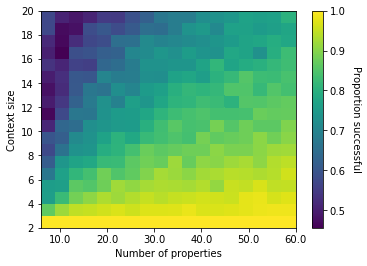

In [634]:
fig, ax = plt.subplots()

cm = ax.pcolormesh(
    num_properties_per_type_grid,
    num_objects_grid, 
    prop_success_results,
#     cmap="Greens"
)

ax.set_xticks(np.linspace(10, 60, 6)/3)
ax.set_xticklabels(np.linspace(10, 60, 6))

cb = fig.colorbar(cm)

ax.set_xlabel("Number of properties")
ax.set_ylabel("Context size")

cb.ax.set_ylabel("Proportion successful", rotation=270, labelpad=15)

w = 5.708
fig.set_size_inches(w, w*0.7)
plt.savefig("frankeSuccess.png", dpi=300)

## Second plot

In [602]:
def second_plot(results, num_properties):    
    
    successful, prop_index, prop_value = results.T
    
    open_scale = prop_value[(prop_index < num_properties)]
    closed_scale = prop_value[((prop_index >= num_properties) & (prop_index < num_properties*2))]
    half_closed_scale = prop_value[(prop_index >= num_properties*2)]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    #### first ax

    ax1.hist(open_scale, bins=100, ec="black", density=True)

    ax1_2 = ax1.twinx()
    xs = np.linspace(-1.5, 1.5, 1000)
    ys = dist_open_pdf(xs)
    ax1_2.plot(xs, ys, color="green")

    #### second ax

    ax2.hist(closed_scale, bins=100, ec="black", density=True)

    ax2_2 = ax2.twinx()
    ax2_2.plot([0,1], [1,1], color="green")

    #### third ax

    ax3.hist(half_closed_scale, bins=60, ec="black", density=True)

    ax3_2 = ax3.twinx()
    xs = np.linspace(0, 2.5, 1000)
    ys = dist_halfopen_pdf(xs)
    ax3_2.plot(xs, ys, color="green")
    
    for axis in [ax1_2, ax2_2, ax3_2]:
        axis.tick_params(axis='y', colors='green')
    
    ax3.set_xlabel("Degrees")
    ax2.set_ylabel("Densities")

    fig.subplots_adjust(hspace=0.4)

    return fig, (ax1, ax2, ax3)

In [635]:
num_properties_per_type = 8
context_size = 30
results = run_single(context_size, num_properties_per_type, num_runs=5000)

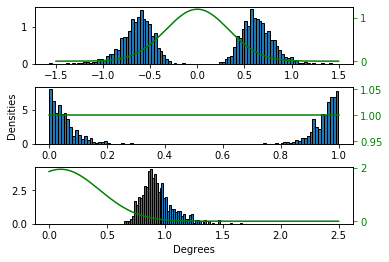

In [636]:
fig, axes = second_plot(results, num_properties_per_type)

w = 5.708
fig.set_size_inches(w, w*0.7)
plt.savefig("frankeSamples.png", dpi=300)